In [7]:
import torch
import pandas as pd
import numpy as np
import numpy.random as npr
import itertools
# from torchvision.datasets import CIFAR10
# from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, CenterCrop

### Number of Quantization Categories

In [8]:
def simulate_probably(n, k, b, s=1000):
    np.random.seed(123)
    count = 0
    for _ in range(s):
        objects = np.random.choice(k, size=(n,))
        batch = np.random.choice(objects, size=(b,), replace=False)
        count += int(len(np.unique(batch)) == k)
    return count / s

In [9]:
n = 50000
b = 512
k = 60

simulate_probably(n, k, b)

0.995

### Raking Estimator

In [10]:
def is_good_event(ix, iy, px, py):
    return len(torch.unique(ix)) == len(px) and len(torch.unique(iy)) == len(py)

def count_freq(X, Y, sizes):
    # count pairs
    pairs = list(zip(X, Y))
    ind, count = np.unique(pairs, axis=0, return_counts=True)
    cmat = np.zeros(sizes)
    cmat[ind[:, 0], ind[:, 1]] = count
    return cmat / len(pairs)

def raking_ratio(X, Y, marginals, num_iter):
    pmat = count_freq(X, Y, (len(marginals[0]), len(marginals[1])))
    if np.sum(np.sum(pmat, axis=1) == 0) + np.sum(np.sum(pmat, axis=0) == 0) > 0:
        raise RuntimeError(
            "Missing mass in this sample. Try a larger sample size.")
        
    est = [pmat]
    for _ in range(num_iter):
        pmat = (marginals[0] / np.sum(pmat, axis=1)).reshape(-1, 1) * pmat
        pmat = pmat * (marginals[1] / np.sum(pmat, axis=0))
        est.append(pmat)
    return est

In [11]:
def generate(pmat, size):
    pairs = np.argwhere(pmat > -1)
    indices = npr.choice(len(pairs), size=size, p=pmat.reshape(-1), replace=True)
    return pairs[indices][:, 0], pairs[indices][:, 1]


In [12]:
npr.seed(552022)  # 05/05/2022

m = 20
prob = npr.rand(m, m)
prob /= np.sum(prob)
px, py = np.sum(prob, axis=1), np.sum(prob, axis=0)

In [13]:
marginals = (px, py)
n = 512
num_iter = 2
X, Y = generate(prob, n)

pmat = count_freq(X, Y, (len(marginals[0]), len(marginals[1])))
# if np.sum(np.sum(pmat, axis=1) == 0) + np.sum(np.sum(pmat, axis=0) == 0) > 0:
#      raise RuntimeError("Missing mass in this sample. Try a larger sample size.")


In [14]:
pmat.shape

(20, 20)

### n

In [17]:
df1 = pd.DataFrame({
    'ind': np.arange(n),
    'bins': [(x, y) for x, y in zip(X, Y)]
})
df1

,ind,bins
0,0,"(7, 8)"
1,1,"(16, 17)"
2,2,"(19, 16)"
3,3,"(12, 10)"
4,4,"(18, 4)"
...,...,...
507,507,"(8, 12)"
508,508,"(6, 18)"
509,509,"(12, 4)"
510,510,"(18, 10)"


In [26]:
df2 = pd.DataFrame(
    {
        'bins': list(itertools.product(np.arange(m), np.arange(m))),
        'prob': pmat.reshape(-1)
    }
)
df2

,bins,prob
0,"(0, 0)",0.000000
1,"(0, 1)",0.000000
2,"(0, 2)",0.000000
3,"(0, 3)",0.000000
4,"(0, 4)",0.001953
...,...,...
395,"(19, 15)",0.003906
396,"(19, 16)",0.003906
397,"(19, 17)",0.000000
398,"(19, 18)",0.001953


In [29]:
bin_names, bin_counts = np.unique(df1['bins'], return_counts=True)

In [30]:
df = df1.merge(df2, on="bins", how="left").merge(pd.DataFrame({'bins': bin_names, 'counts': bin_counts}), on="bins", how="left")

In [31]:
weight = df['prob'].to_numpy() / np.maximum(1.0, df['counts'].to_numpy())

In [33]:
weight.sum()

1.0

### n^2

In [11]:
df1 = pd.DataFrame(
    {
        'ind': list(itertools.product(np.arange(n), np.arange(n))),
        'bins': list(itertools.product(X, Y)),
    }
)
df2 = pd.DataFrame(
    {
        'bins': list(itertools.product(np.arange(m), np.arange(m))),
        'prob': pmat.reshape(-1)
    }
)
bin_names, bin_counts = np.unique(df1['bins'], return_counts=True)
# df3 = pd.DataFrame({'bins': [tuple(x) for x in observed_bins], "counts": observed_counts})
# df = df1.merge(df2.merge(df3, on="bins", how="left").fillna(0.0), on="bins", how="left")
df = df1.merge(df2, on="bins", how="left").merge(pd.DataFrame({'bins': bin_names, 'counts': bin_counts}), on="bins", how="left")
weight = df['prob'].to_numpy() / np.maximum(1.0, df['counts'].to_numpy())
df

,ind,bins,prob,counts
0,"(0, 0)","(7, 8)",0.005859,726
1,"(0, 1)","(7, 17)",0.000000,660
2,"(0, 2)","(7, 16)",0.003906,792
3,"(0, 3)","(7, 10)",0.007812,1023
4,"(0, 4)","(7, 4)",0.000000,759
...,...,...,...,...
262139,"(511, 507)","(3, 12)",0.001953,783
262140,"(511, 508)","(3, 18)",0.000000,567
262141,"(511, 509)","(3, 4)",0.001953,621
262142,"(511, 510)","(3, 10)",0.005859,837


In [12]:
weight.sum()

1.0

In [13]:
idx = np.random.choice(np.arange(n ** 2), size=n, replace=True, p=weight)

In [14]:
new_pairs = df['ind'].iloc[idx]

In [15]:
bout = np.array(list(df['bins'].iloc[idx]))
cx, cy = bout[:, 0], bout[:, 1]

In [16]:
cx

array([ 2,  4, 16,  4,  5,  4,  2,  8, 12,  2, 19,  8,  7, 11, 15, 10,  2,
       12,  9, 12,  3, 18, 13,  4, 16, 12,  9, 16,  3, 13, 17, 11,  1, 18,
        6,  5,  0,  6,  8,  8,  0,  9, 11, 15, 11, 15, 12,  8,  5,  3,  6,
        4, 14, 12,  7, 11, 14, 12, 10,  7,  2,  6,  4,  5, 15, 13,  3,  2,
       11, 10, 16, 16,  9,  5, 11,  9,  1, 15, 12, 18, 11, 12,  7,  8, 14,
        5, 17, 16, 15,  0, 17,  0, 11,  1,  0, 17, 15, 17,  8,  6, 11,  6,
       11, 19, 15,  6,  0, 14,  8,  6, 18, 12, 15,  9, 19, 18,  6,  7,  7,
       10, 12,  3,  5, 19, 19,  9, 12,  6, 13,  1,  7,  7,  4,  9, 10, 15,
       16, 11, 16,  2, 16, 17, 11, 14,  0,  7,  6, 14,  7, 11,  2, 17,  2,
        0,  7,  4,  5, 15, 18,  6,  8,  4,  5,  3, 15, 14,  4, 15, 19, 11,
        7,  4, 10, 18, 16, 17, 18,  9, 16, 18,  4, 12, 13,  7,  3, 11, 12,
        0, 15, 15,  9, 17,  6, 14, 12,  4,  2, 15, 11, 15,  6, 19,  4, 19,
        8, 16,  0,  2, 10, 17,  7, 18, 13, 13, 13, 15, 12, 11, 17, 19, 10,
        3, 11, 19,  9,  9

In [18]:
# x_new, y_new = [X[i] for i, j in new_pairs], [Y[j] for i, j in new_pairs]

In [17]:
pmat2, observed_bins, observed_counts = count_freq(cx, cy, (len(marginals[0]), len(marginals[1])))

In [18]:
pmat.shape

(20, 20)

In [19]:
pmat2.shape

(20, 20)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

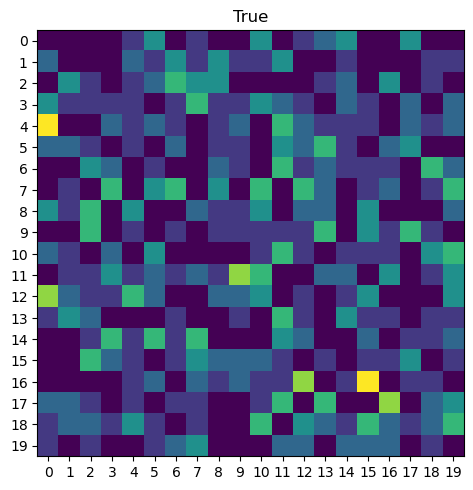

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(pmat)
ax.set_xticks(np.arange(pmat.shape[0]))
ax.set_yticks(np.arange(pmat.shape[1]))
fig.tight_layout()
ax.set_title("True")
plt.show()

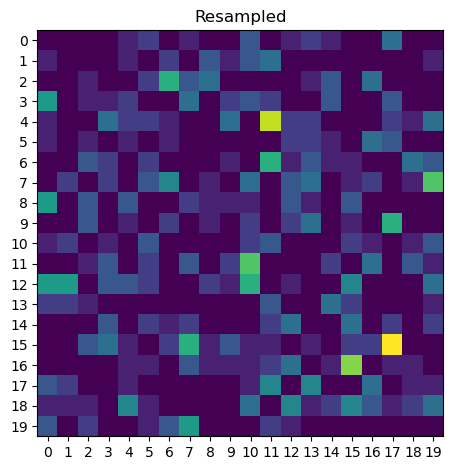

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(pmat2)
ax.set_xticks(np.arange(pmat.shape[0]))
ax.set_yticks(np.arange(pmat.shape[1]))
ax.set_title("Resampled")
fig.tight_layout()
plt.show()